# Experiment for downstream localization models at ITB

In [1]:
# Dataset: MDCC Data Set 
# Candidates for downstream models:
# KNN, Random Forest (RF), Decision Tree (DT) and Gasussian Processes (GSs)

In [2]:
import numpy as np
import json
import math
import glob
import os
import google.protobuf
from collections import Counter
import matplotlib.pyplot as plt
import sklearn
import pandas as pd 
from pandas import DataFrame, concat
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy import linalg as LA
import statistics

# Data Cleaning and Exploration

In [3]:
buildingname =  'ITB'
floorlevel = 2

In [4]:
import Data_pb2
from Utils import distance,offset_coord,gps_fromxy,gps2local,get_file_list,load_data_packs,location_interpolate
from Utils import parse_path_packages,parse_point_packages

#load building information
with open('building_dict.json') as fin:
    building_dict = json.load(fin)

#find a reference gps location for a local coordinate system
gpspo = np.array(building_dict[buildingname]['gpspo'])
gps_origin=tuple(np.min(gpspo,axis=0))

In [5]:
#Load the data packages
data_folder = os.path.join('FpData',buildingname,str(floorlevel))
print('The data folder is in:',data_folder)
#1. Load path-based data and verify the building and floor level
path_packages = []
path_data_files = get_file_list(data_folder, 1)
if len(path_data_files)>0:
    path_packages = load_data_packs(path_data_files)
    for i,path_package in enumerate(path_packages):
        assert path_package.buildingName==buildingname, "building mismatch, delete file and retry: "+path_data_files[i]
        assert int(path_package.floorLevel)==int(floorlevel), "floor mismatch, delete fine and retry:"+path_data_files[i]
print('The number of path-based collection',len(path_packages))
print(path_data_files)
point_packages = []
point_data_files = get_file_list(data_folder, 2)
if len(point_data_files)>0:
    point_packages = load_data_packs(point_data_files)
    for i,point_package in enumerate(point_packages):
        assert point_package.buildingName==buildingname, "building  mismatch,delete file and retry:"+point_data_files[i]
        assert int(point_package.floorLevel)==int(floorlevel), "floor  mismatch,delete file and retry:"+point_data_files[i]
print('The number of point-based collection',len(point_packages))
test_packages = []
test_data_files = get_file_list(os.path.join('FpData',buildingname,str(floorlevel),'test'), 2)
if len(test_data_files)>0:
    test_packages = load_data_packs(test_data_files)
    for test_package in point_packages:
        assert test_package.buildingName==buildingname, "building name mismatch"
        assert test_package.floorLevel==floorlevel, "floor level mismatch"
print('The number of test points',len(test_packages))


The data folder is in: FpData/ITB/2
The number of path-based collection 13
['/Users/lawrence/Downloads/IPS/FpData/ITB/2/weiy49_1_20190831143225 2.pbf', '/Users/lawrence/Downloads/IPS/FpData/ITB/2/weiy49_1_20190831143446.pbf', '/Users/lawrence/Downloads/IPS/FpData/ITB/2/weiy49_1_20190831143326.pbf', '/Users/lawrence/Downloads/IPS/FpData/ITB/2/weiy49_1_20190831144001.pbf', '/Users/lawrence/Downloads/IPS/FpData/ITB/2/weiy49_1_20181217125220.pbf', '/Users/lawrence/Downloads/IPS/FpData/ITB/2/weiy49_1_20190831143225.pbf', '/Users/lawrence/Downloads/IPS/FpData/ITB/2/weiy49_1_20190831143758.pbf', '/Users/lawrence/Downloads/IPS/FpData/ITB/2/weiy49_1_20190831143639.pbf', '/Users/lawrence/Downloads/IPS/FpData/ITB/2/liu433_1_20190906223222.pbf', '/Users/lawrence/Downloads/IPS/FpData/ITB/2/weiy49_1_20181217125220 2.pbf', '/Users/lawrence/Downloads/IPS/FpData/ITB/2/weiy49_1_20190831143639 2.pbf', '/Users/lawrence/Downloads/IPS/FpData/ITB/2/weiy49_1_20190905113658.pbf', '/Users/lawrence/Downloads/IPS

# Select APs

In [6]:
# APs seen by less than this value will be ignored.
Freq_threshold = 60
#Select the Effective Access Points since some Access Points may just temporary
AP_bssids = []
for pack in point_packages:
    for e in pack.rssItems:
        AP_bssids.append(e.bssid)
for pack in path_packages:
    for e in pack.rssItems:
        AP_bssids.append(e.bssid)
AP_bssids_count = dict(Counter(AP_bssids))
#remove APs only seen sporadically. 
AP_bssids_common = {k:v for k,v in AP_bssids_count.items() if v > Freq_threshold}
#create a dict for the AP_bssid index for convenience to organize the fingerprint vector
AP_bssids_index_dict = {k:v for k,v in zip(AP_bssids_common.keys(),range(len(AP_bssids_common)))}

if len(AP_bssids_index_dict)<3:
    print('Error, AP_bssids_index_dict is too small, please collect more data or set Freq_threshold to a smaller value')

In [8]:
path_FPs, path_labels = parse_path_packages(path_packages,AP_bssids_index_dict)
point_FPs, point_labels = parse_point_packages(point_packages,AP_bssids_index_dict)
test_FPs, test_labels = parse_point_packages(test_packages,AP_bssids_index_dict)

path length is 25.547495 meter
path length is 36.974165 meter
path length is 25.491630 meter
path length is 50.155285 meter
path length is 25.950005 meter
path length is 25.547495 meter
path length is 25.151754 meter
path length is 63.627606 meter
path length is 25.590166 meter
path length is 25.950005 meter
path length is 63.627606 meter
path length is 25.364043 meter
path length is 20.501812 meter


# Locations Visualization
The following code will visualize the locations where you collected data, including the path-based, point-based and test data. Please note that the location labels are converted to a local coorndinate system instead of GPS locations.

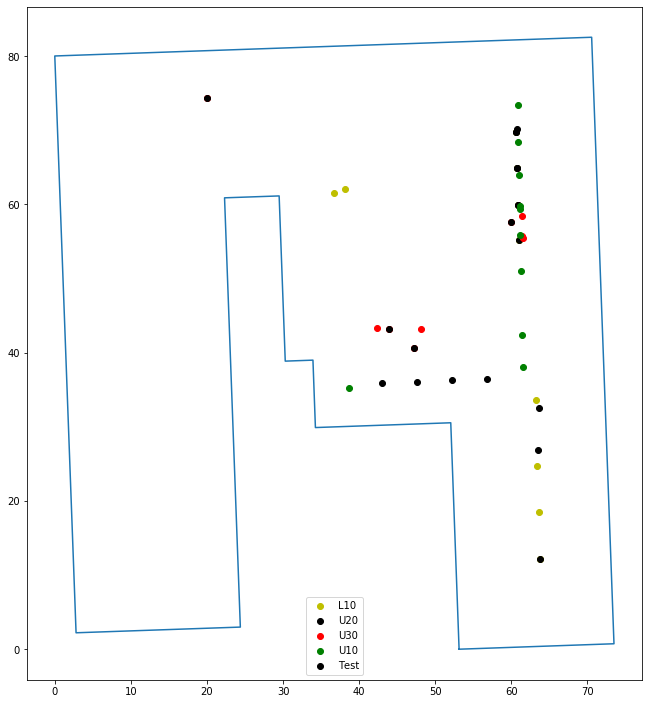

In [49]:
#plot your target building structure and the locations you collected data
local_poly = [offset_coord(gps_origin[1],gps_origin[0],lat,lon) for lon,lat in gpspo]
x_scale,y_scale=np.max(local_poly,axis=0) - np.min(local_poly,axis=0)
fig, ax = plt.subplots(1, 1, figsize=(x_scale*0.15,y_scale*0.15)) 
local_poly = np.array(local_poly)
ax.plot(*zip(*local_poly))

path_locs = gps2local(gps_origin,path_labels)
point_locs = gps2local(gps_origin,point_labels)
test_locs = gps2local(gps_origin,test_labels)
train_data = pd.DataFrame(np.array(path_FPs + point_FPs),index=None, columns=None)
train_locs = pd.DataFrame(np.array(path_locs + point_locs),index=None, columns=None)
train_data = pd.concat([train_data,train_locs],axis=1)
train_data = train_data.dropna()

# ax.scatter(np.array(train_data)[:,-2],np.array(train_data)[:,-1],c='pink',marker='.',label="Collected Along Paths")


#label
ax.scatter(np.array(train_data)[50:60][:,-2],np.array(train_data)[50:60][:,-1],c='y',marker='o',label="L10")
# unlabeled 2
ax.scatter(np.array(train_data)[35:40][:,-2],np.array(train_data)[35:40][:,-1],c='black',marker='o',label="U20")
ax.scatter(np.array(train_data)[55:60][:,-2],np.array(train_data)[55:60][:,-1],c='black',marker='o')
#unlabeled 3
ax.scatter(np.array(train_data)[75:80][:,-2],np.array(train_data)[75:80][:,-1],c='red',marker='o',label="U30")
ax.scatter(np.array(train_data)[80:85][:,-2],np.array(train_data)[80:85][:,-1],c='red',marker='o')
#unlabeled 1
ax.scatter(np.array(train_data)[10:15][:,-2],np.array(train_data)[10:15][:,-1],c='g',marker='o',label="U10")
ax.scatter(np.array(train_data)[5:10][:,-2], np.array(train_data)[5:10][:,-1],c='g',marker='o')
#testing
ax.scatter(np.array(train_data)[70:73][:,-2],np.array(train_data)[70:73][:,-1],c='black',marker='o',label="Test")
ax.scatter(np.array(train_data)[68:70][:,-2],np.array(train_data)[68:70][:,-1],c='black',marker='o')
ax.scatter(np.array(train_data)[82:85][:,-2],np.array(train_data)[82:85][:,-1],c='black',marker='o')
ax.scatter(np.array(train_data)[79:81][:,-2],np.array(train_data)[79:81][:,-1],c='black',marker='o')

ax.legend()
plt.show()


# Downstream model performacne evaluation

In [10]:
training_data = pd.concat([train_data[50:60],train_data[35:40],
                           train_data[55:60],train_data[75:80],
                           train_data[79:85],train_data[10:15],
                           train_data[5:10]],axis=0).to_numpy()

In [11]:
test_data = pd.concat([train_data[70:73],train_data[68:70],
                       train_data[82:85],train_data[78:81]],axis=0).to_numpy()

In [12]:
training_data_10L =  training_data[:10]
training_data_10U =  training_data[10:20]
training_data_20L =  training_data[:20]
training_data_20U =  training_data[10:30]
training_data_30L =  training_data[:30]
training_data_30U =  training_data[10:40]
training_data_40L =  training_data[:40]

In [13]:
import downstream_models.localization_models as models
import importlib
importlib.reload(models)

<module 'downstream_models.localization_models' from '/Users/lawrence/Downloads/IPS/downstream_models/localization_models.py'>

In [ ]:
# Label Propagation and Propagation errors

In [14]:
import DG_SSL.dg_ssl as dg_ssl
importlib.reload(dg_ssl)

<module 'DG_SSL.dg_ssl' from '/Users/lawrence/Downloads/IPS/DG_SSL/dg_ssl.py'>

In [15]:
propagation_results_10L_10U = dg_ssl.dg_ssl_int(training_data_10L,training_data_10U)[0]
# print (dg_ssl.prop_error(propagation_results_10L_10U[10:,-2:],training_data_10U[:,-2:]))
# print (dg_ssl.prop_error(propagation_results_10L_10U[:10,-2:],training_data_10L[:,-2:]))

3.6425891469926084
1.1692650500374242


In [16]:
propagation_results_10L_20U = dg_ssl.dg_ssl_int(training_data_10L,training_data_20U)[0]
# print (dg_ssl.prop_error(propagation_results_10L_20U[10:,-2:],training_data_20U[:,-2:]))
# print (dg_ssl.prop_error(propagation_results_10L_20U[:10,-2:],training_data_10L[:,-2:]))

11.554030749873945
14.65189262678312


In [17]:
propagation_results_10L_30U = dg_ssl.dg_ssl_int(training_data_10L,training_data_30U)[0]
# print (dg_ssl.prop_error(propagation_results_10L_30U[10:,-2:],training_data_30U[:,-2:]))
# print (dg_ssl.prop_error(propagation_results_10L_30U[:10,-2:],training_data_10L[:,-2:]))

12.12715193427589
18.016471475304435


In [ ]:
# model performance of KNN, DT and RF for different training data 

In [18]:
downstream_models_results_10L = models.evaluation_reg(training_data_10L,test_data,[10,0])
downstream_models_results_20L = models.evaluation_reg(training_data_20L,test_data,[20,0])
downstream_models_results_30L = models.evaluation_reg(training_data_30L,test_data,[30,0])
downstream_models_results_40L = models.evaluation_reg(training_data_40L,test_data,[40,0])
downstream_models_results_10L_10U = models.evaluation_reg(propagation_results_10L_10U,test_data,[10,10])
downstream_models_results_10L_20U = models.evaluation_reg(propagation_results_10L_20U,test_data,[10,20])
downstream_models_results_10L_30U = models.evaluation_reg(propagation_results_10L_30U,test_data,[10,30])

Knn error(m) - 27.08545378751104
Random Forest error(m)- 18.95539533615441
Decision Tree error(m)- 28.438992537682704
 
Knn error(m) - 19.933984734612793
Random Forest error(m)- 16.18687803215708
Decision Tree error(m)- 34.28631243960718
 
Knn error(m) - 0.2145228322587014
Random Forest error(m)- 10.824332947900075
Decision Tree error(m)- 3.1352710161938453
 
Knn error(m) - 0.2145228322587014
Random Forest error(m)- 8.784064520684733
Decision Tree error(m)- 0.2145228322587014
 
Knn error(m) - 20.336442999513483
Random Forest error(m)- 18.220242307847023
Decision Tree error(m)- 26.887658744200472
 
Knn error(m) - 16.805524545584607
Random Forest error(m)- 16.880094068662316
Decision Tree error(m)- 16.974067762607774
 
Knn error(m) - 14.289517172429838
Random Forest error(m)- 14.58286692420043
Decision Tree error(m)- 14.617388263843337
 


In [ ]:
# Model performance of GPs for different training data 

In [43]:
# Train GPs 
import importlib
import gps_deployment.gps_starting as gps
import gps_deployment.main_controller as gps1
import gps_deployment.gaussian as gps2
importlib.reload(gps)
importlib.reload(gps1)
importlib.reload(gps2)

<module 'gps_deployment.gaussian' from '/Users/lawrence/Downloads/IPS/gps_deployment/gaussian.py'>

In [41]:
gps_results_10L = gps.gps_start(10,training_data_10L)
gps_results_20L = gps.gps_start(10,training_data_20L)
gps_results_30L = gps.gps_start(10,training_data_30L)
gps_results_40L = gps.gps_start(10,training_data_40L)
gps_results_10L_10L = gps.gps_start(10,propagation_results_10L_10U)
gps_results_10L_20L = gps.gps_start(10,propagation_results_10L_20U)
gps_results_10L_30L = gps.gps_start(10,propagation_results_10L_30U)

In [42]:
rlt_10L = gps.gps_evaluation(gps_results_10L,10,test_data,[10,0])
rlt_20L = gps.gps_evaluation(gps_results_20L,10,test_data,[20,0])
rlt_30L = gps.gps_evaluation(gps_results_30L,10,test_data,[30,0])
rlt_40L = gps.gps_evaluation(gps_results_40L,10,test_data,[40,0])

GPs error: 21.33528441870358
GPs error: 18.901067855732165
GPs error: 23.64131221019636
GPs error: 15.750106735628847


In [44]:
rlt_10L_10U = gps.gps_evaluation(gps_results_10L_10L,10,test_data,[10,10])
rlt_10L_20U = gps.gps_evaluation(gps_results_10L_20L,10,test_data,[10,20])
rlt_10L_30U = gps.gps_evaluation(gps_results_10L_30L,10,test_data,[10,30])

GPs error: 23.901067855732165
GPs error: 9.931105807713436
GPs error: 12.108546330091528
